In [39]:
import os
import pandas as pd
from datasets import load_dataset, concatenate_datasets, interleave_datasets
import pyarrow.dataset as ds
from pyarrow.parquet import ParquetFile
import pyarrow as pa 
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from collections import Counter
from curlyBrace import curlyBrace
%matplotlib inline

In [21]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array = array + 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

def lorenz(arr):
    # this divides the prefix sum by the total sum
    # this ensures all the values are between 0 and 1.0
    scaled_prefix_sum = arr.cumsum() / arr.sum()
    # this prepends the 0 value (because 0% of all people have 0% of all wealth)
    return np.insert(scaled_prefix_sum, 0, 0)

In [11]:
# !cp /data/ebay/notebooks/beucar/PSU_Summarization/paper_evaluation/OURS_PRECISION\&RECALL\&F1.ipynb ./

In [33]:
def read_parquet(data_path, n):
    num_path_list = []
    # n = 50
    # data_path = "/data/ebay/data/eRUPT_Summarisation/processed_data/dataset_20231009_20231209_performancefrom20231209"

    for file_name in os.listdir(data_path):
        if file_name.startswith("num_") and "train." in file_name:
            file_path = os.path.join(data_path, file_name)
            # num_data_files[file_name] = file_path
            num_path_list.append(file_path)

    # dfs = [ds.dataset(d).scanner().head(n).to_pandas() for d in num_path_list]
    dfs = []
    for f in num_path_list:
        pf = ParquetFile(f) 
        first_ten_rows = next(pf.iter_batches(batch_size = n)) 
        df = pa.Table.from_batches([first_ten_rows]).to_pandas()
        dfs.append(df)

    df = pd.concat(dfs, axis=0, ignore_index=True)
    return df

In [12]:
def read_csv(data_path):
    num_path_list = []
    n = 50
    # data_path = "/data/ebay/data/eRUPT_Summarisation/processed_data/dataset_20231009_20231209_performancefrom20231209"

    for file_name in os.listdir(data_path):
        if file_name.startswith("num_") and "train." in file_name:
            file_path = os.path.join(data_path, file_name)
            # num_data_files[file_name] = file_path
            num_path_list.append(file_path)

    # dfs = [ds.dataset(d).scanner().head(n).to_pandas() for d in num_path_list]
    dfs = []
    for f in num_path_list:
        d = pd.read_csv(f)
        dfs.append(d)
        # pf = ParquetFile(f) 
        # first_ten_rows = next(pf.iter_batches(batch_size = n)) 
        # df = pa.Table.from_batches([first_ten_rows]).to_pandas()
        # dfs.append(df)

    df = pd.concat(dfs, axis=0, ignore_index=True)
    return df

In [27]:
amazoncat_path = "/data/ebay/data/eRUPT_Summarisation/data/processed_data/AmazonCat-13K"
eurlex_path = "/data/ebay/data/eRUPT_Summarisation/data/processed_data/Eurlex-4.3K"
wiki_path = "/data/ebay/data/eRUPT_Summarisation/data/processed_data/Wikipedia-1M"

In [35]:
ebay_path = "/data/ebay/data/eRUPT_Summarisation/processed_data/dataset_20231009_20231209_performancefrom20231209"
n = 100000
ebay_df = read_parquet(ebay_path, n)


In [30]:
wiki_df = read_csv(wiki_path)

In [17]:
amazoncat_df = read_csv(amazoncat_path)

In [28]:
eurlex_df = read_csv(eurlex_path)

In [18]:
amazoncat_df.columns

Index(['uid', 'text', 'target', 'num_keyphrases'], dtype='object')

In [26]:
# amazoncat_df['uid'][:10]
def gini_train(df):
    df["num_keyphrases"] = df["target"].str.count(";") + 1
    gini_coef = gini(np.array(df["num_keyphrases"]))
    return gini_coef
print(gini_train(amazoncat_df))

0.3373072239263449


In [29]:
print(gini_train(eurlex_df))

0.28883953872563906


In [31]:
print(gini_train(wiki_df))

0.4192950160502077


In [36]:
print(gini_train(ebay_df))

0.3112020734850702


keyphrase Number
50% quantile 4.0
90% quantile 9.0
median num_keyphrases 4.0
mean num_keyphrases 5.061020130546046
var num_keyphrases 12.415751931709996


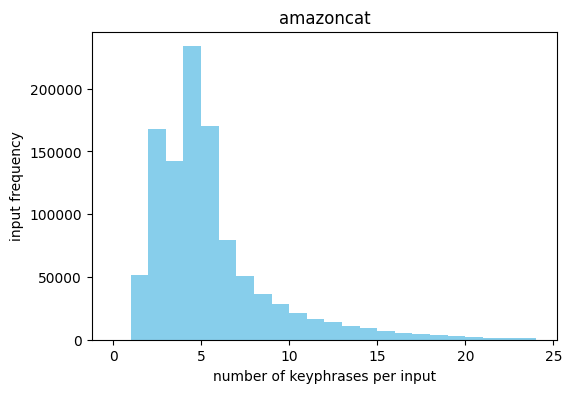

In [48]:
def vis_keyphrase_num(df, name):
    # plt.close()
    df['num_keyphrases'] = df['target'].str.count(';') + 1
    # df['num_keyphrases'] = df['target'].str.count(';') + 1
    num_pairs = len(df)
    mean_keyphrases = df['num_keyphrases'].mean()
    fig = plt.figure(figsize=(6,4))
    # Plot the distribution as a bar plot
    counts, bins, patches = plt.hist(df['num_keyphrases'], bins=range(25), color='skyblue')

    plt.xlabel('number of keyphrases per input')
    plt.ylabel('input frequency')
    plt.title(name)
    # plt.title(f'Number of Keyphrases in Target Column \n({num_pairs} item-keyphrases pairs; Mean={mean_keyphrases:.2f})\n\n')
#     CUT = 300000
#     # Add count labels to the top of each bar
#     for i in range(len(counts)):
#         if counts[i] > 0:
#             if counts[i] > CUT: 
#                 plt.text(x=bins[i]+0.25, y=CUT, s=int(counts[i]), fontweight='bold', rotation=45)
#             else:
#                 plt.text(x=bins[i]+0.25, y=counts[i]+0.1, s=int(counts[i]), fontweight='bold', rotation=45)

#     # Adjust y-axis limits to omit uninformative range
#     plt.ylim(0, CUT)
    column_name = 'num_keyphrases'
    mean = df[column_name].mean()
    var = df[column_name].var()
    print("keyphrase Number")
    print(f"50% quantile", df[column_name].quantile(0.5))
    print(f"90% quantile", df[column_name].quantile(0.9))
    print(f"median {column_name}", df[column_name].median())

    print(f"mean {column_name}", mean)
    print(f"var {column_name}", var)
    fig.savefig(f"./figures/{name}_keyphrase_num.png")
    plt.show()
    # fig.close()
vis_keyphrase_num(amazoncat_df, "amazoncat")

keyphrase Number
50% quantile 14.0
90% quantile 28.0
median num_keyphrases 14.0
mean num_keyphrases 15.946459049355871
var num_keyphrases 75.42448892268001


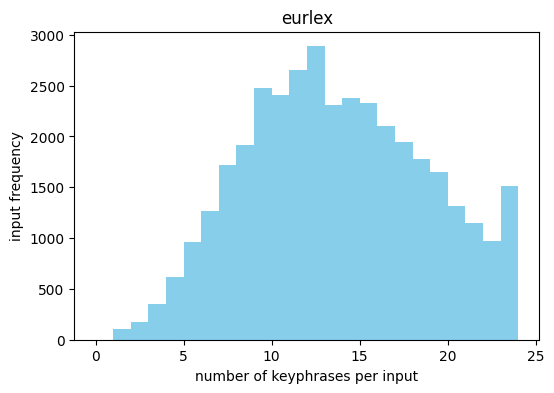

In [50]:
vis_keyphrase_num(eurlex_df, "eurlex")

keyphrase Number
50% quantile 4.0
90% quantile 10.0
median num_keyphrases 4.0
mean num_keyphrases 4.907075502081357
var num_keyphrases 20.076676850460736


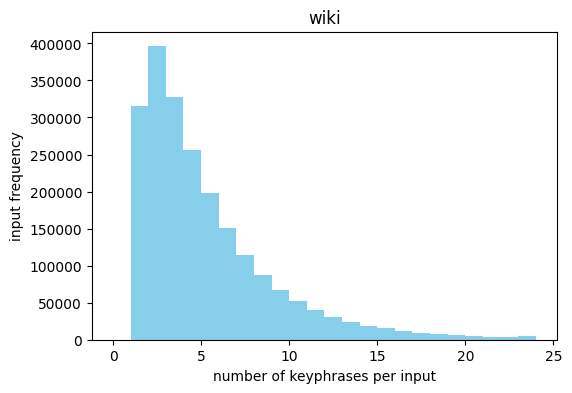

In [51]:
vis_keyphrase_num(wiki_df, "wiki")

keyphrase Number
50% quantile 4.0
90% quantile 8.0
median num_keyphrases 4.0
mean num_keyphrases 4.583623520427644
var num_keyphrases 6.284588225054816


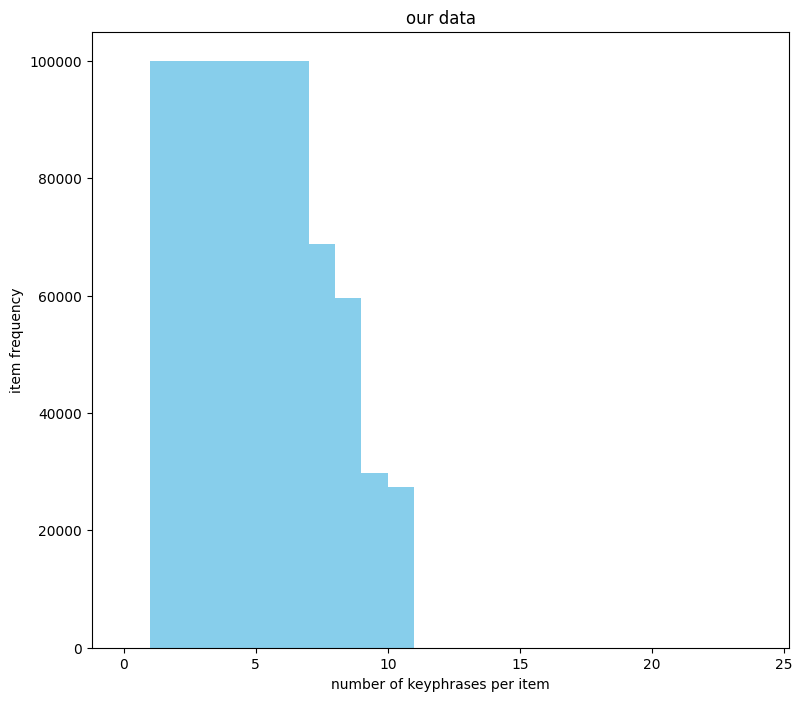

In [46]:
vis_keyphrase_num(ebay_df, "our data")